In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import missingno as msno

In [2]:
df=pd.read_csv('Base_Problem_DataSet.csv',low_memory=False)
num_feat=[x for x in df.columns if df[x].dtype!='O']
cat_feat=[x for x in df.columns if df[x].dtype=='O']

#categorical values  that are wrongly flaagged as numericals


# Preprocessing


### Changing Improper Categories and Numerics

In [3]:
imporoper_categories={ x:len(df[x].value_counts()) for x in cat_feat if len(df[x].value_counts())> 30 and  len(df[x].value_counts())!=58 }
#numerical values  that are wrongly flaagged as categories
improper_numeric={x:len(df[x].value_counts()) for x in num_feat if len(df[x].value_counts())< 30}
num_feat.extend(imporoper_categories.keys())
num_feat=[ x for x in num_feat if x not in improper_numeric]
cat_feat.extend(improper_numeric.keys())
cat_feat=[ x for x in cat_feat if x not in imporoper_categories]
for i in imporoper_categories.keys() :
    df[i].replace(['#VALUE!','@','#','x','$','&'],0,inplace=True)
    df[i]=df[i].astype('float')
for i in improper_numeric.keys():
    df[i]=df[i].astype(object)

## Handling Missing Data

<Axes: >

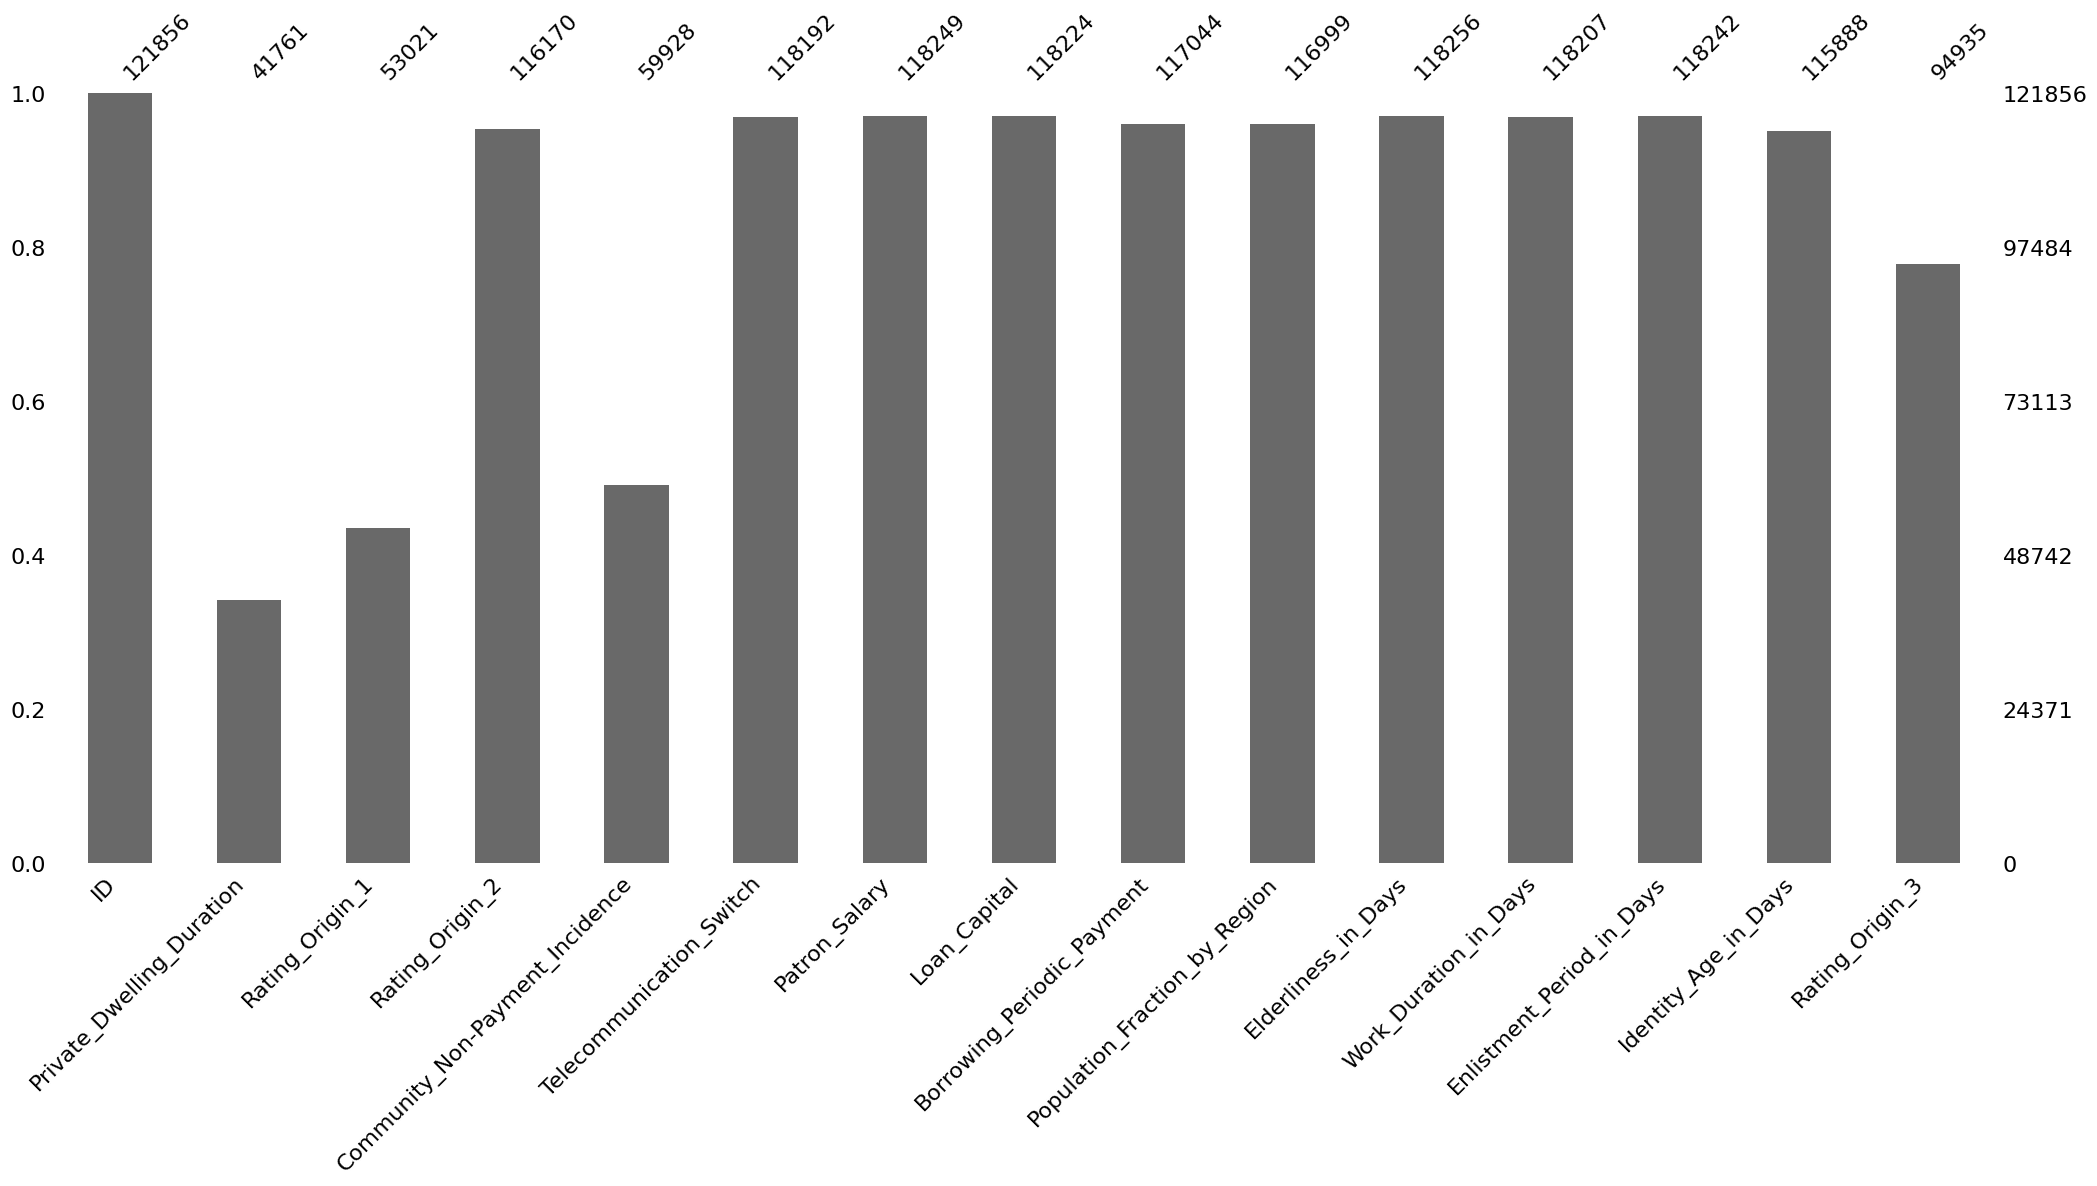

In [4]:
msno.bar(df[num_feat])

<Axes: >

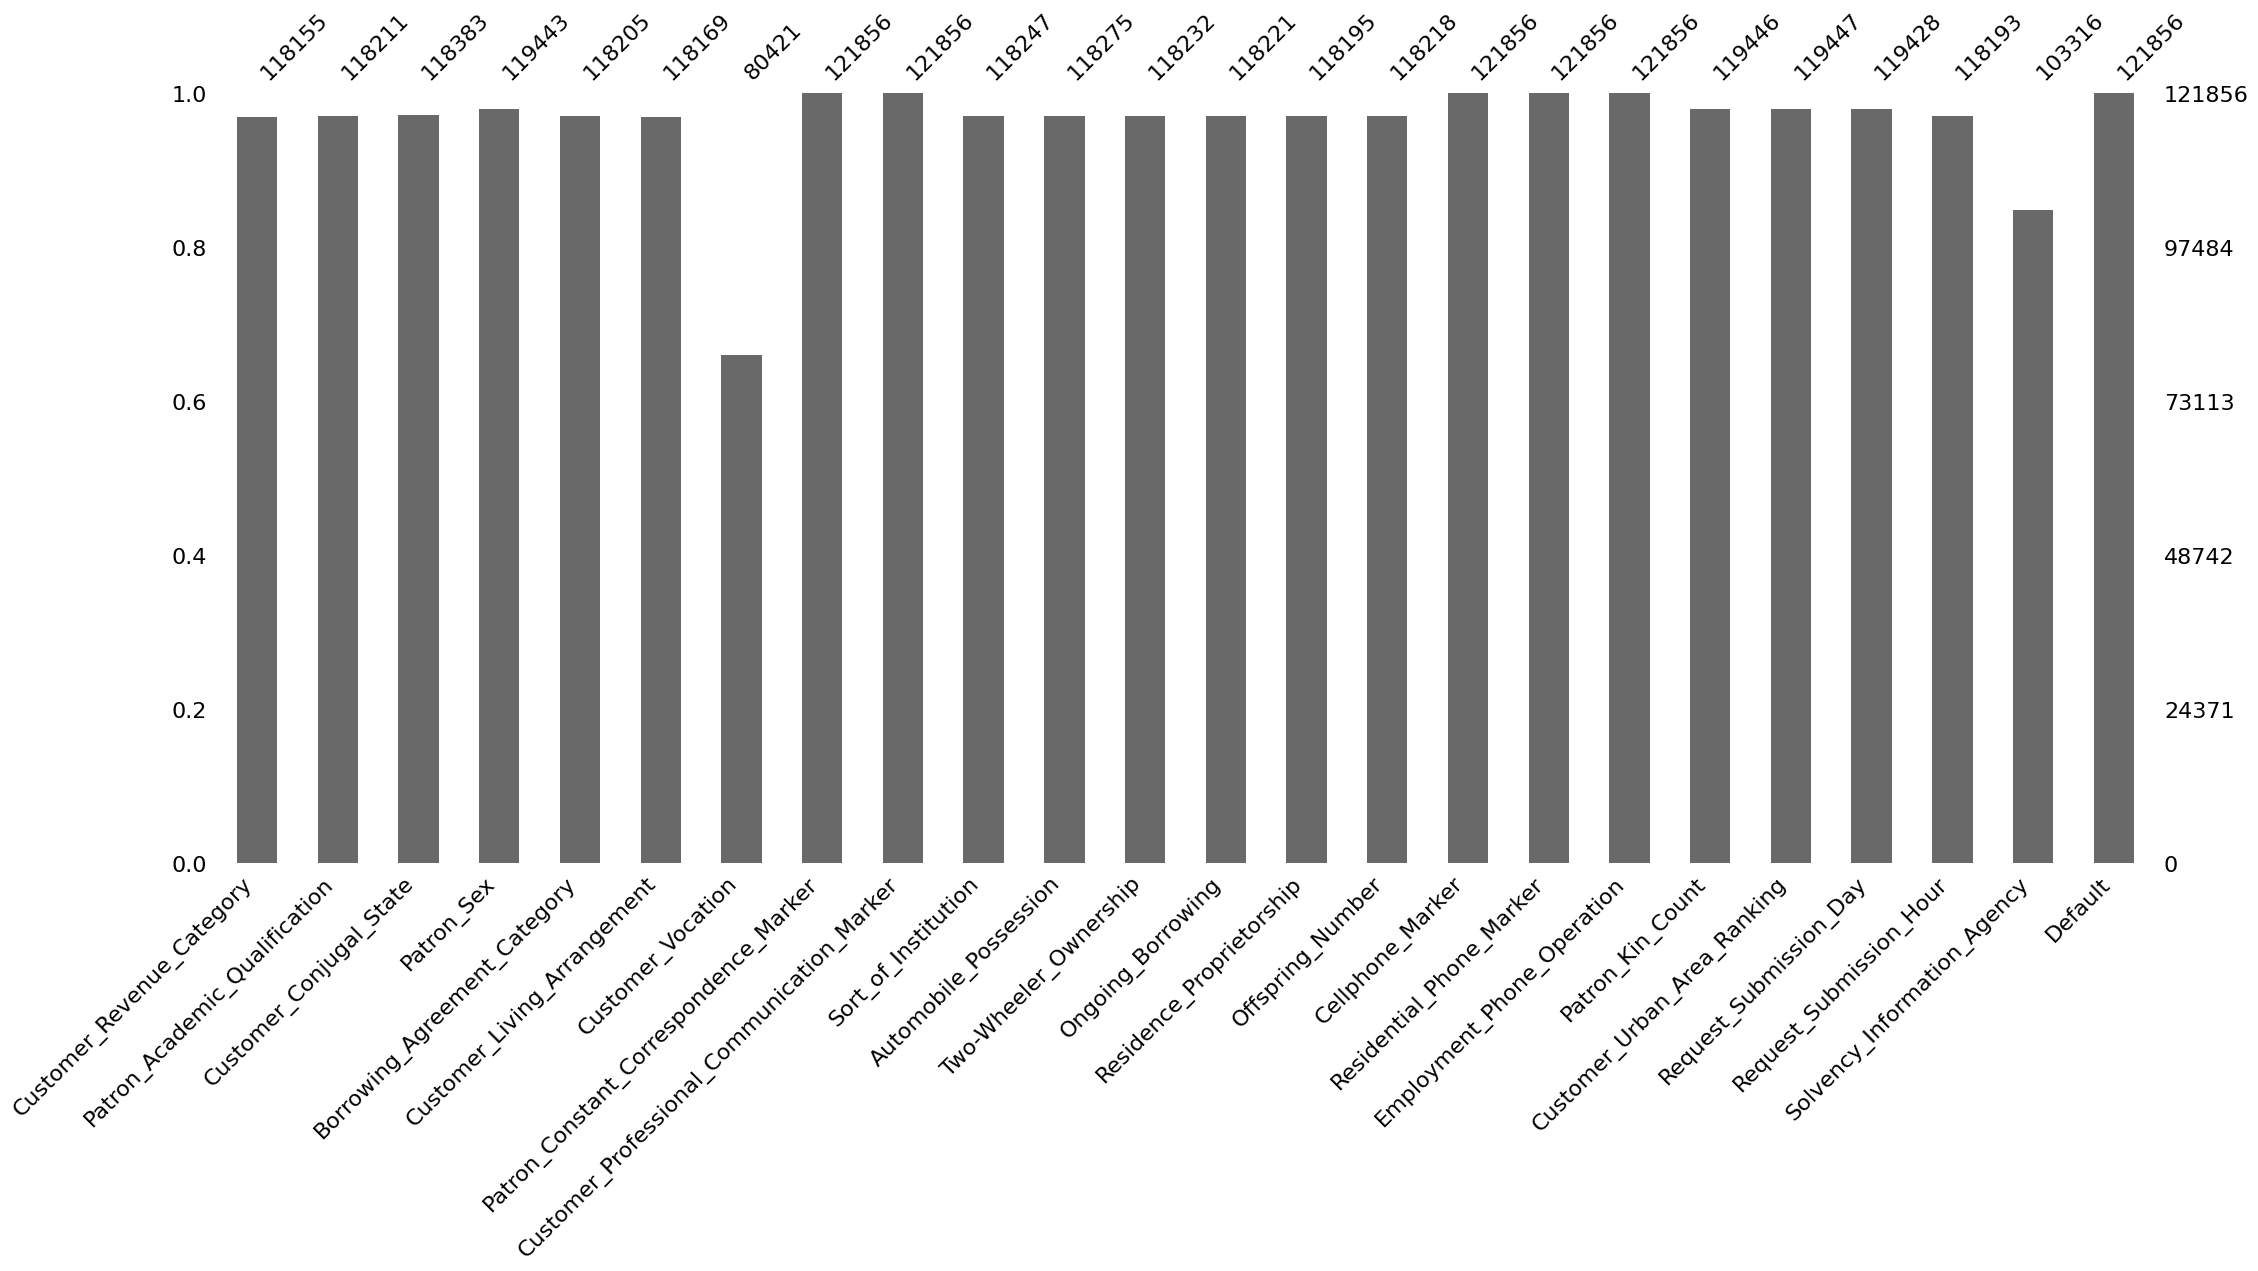

In [5]:
msno.bar(df[cat_feat])

### KNN Imputation for numerical features


In [6]:
from sklearn.impute import KNNImputer
knn_imp=KNNImputer(n_neighbors=2)
# df=knn_imp.fit_transform()
for i,j in enumerate(num_feat):
    print(j)
    df[j]=knn_imp.fit_transform(df[[j]])

ID
Private_Dwelling_Duration
Rating_Origin_1
Rating_Origin_2
Community_Non-Payment_Incidence
Telecommunication_Switch
Patron_Salary
Loan_Capital
Borrowing_Periodic_Payment
Population_Fraction_by_Region
Elderliness_in_Days
Work_Duration_in_Days
Enlistment_Period_in_Days
Identity_Age_in_Days
Rating_Origin_3


### Impute Missing Values for Categorical Features

In [7]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='most_frequent')
df[cat_feat]=imputer.fit_transform(df[cat_feat])

## Outlier Capping for Numerical Features:


In [8]:
def detect_outliers(col):
    # Finding the IQR
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    print('\n ####', col , '####')
    print("percentile25",percentile25)
    print("percentile75",percentile75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    df.loc[(df[col]>upper_limit), col]= upper_limit
    df.loc[(df[col]<lower_limit), col]= lower_limit    
    return df

In [9]:
for i in num_feat:
    detect_outliers(i)


 #### ID ####
percentile25 12130464.75
percentile75 12191392.25
Upper limit 12282783.5
Lower limit 12039073.5

 #### Private_Dwelling_Duration ####
percentile25 12.157323818874069
percentile75 12.157323818874069
Upper limit 12.157323818874069
Lower limit 12.157323818874069

 #### Rating_Origin_1 ####
percentile25 0.5012129250527902
percentile75 0.5012129250527902
Upper limit 0.5012129250527902
Lower limit 0.5012129250527902

 #### Rating_Origin_2 ####
percentile25 0.40199560075
percentile75 0.659828416
Upper limit 1.0465776388749999
Lower limit 0.015246377875000106

 #### Community_Non-Payment_Incidence ####
percentile25 0.0907
percentile75 0.11742785509277799
Upper limit 0.15751963773194497
Lower limit 0.05060821736083302

 #### Telecommunication_Switch ####
percentile25 287.0
percentile75 1550.0
Upper limit 3444.5
Lower limit -1607.5

 #### Patron_Salary ####
percentile25 11250.0
percentile75 20250.0
Upper limit 33750.0
Lower limit -2250.0

 #### Loan_Capital ####
percentile25 27450

## Encoding Categorical features

In [10]:
for i in cat_feat:
    print(len(df[i].value_counts()))
    print(df[i].value_counts(normalize=True)*100)
    print("***____****")
    

8
Customer_Revenue_Category
Service            53.119256
Commercial         22.784270
Retired            17.268743
Govt Job            6.813780
Student             0.006565
Unemployed          0.004924
Maternity leave     0.001641
Businessman         0.000821
Name: proportion, dtype: float64
***____****
5
Patron_Academic_Qualification
Secondary             71.852022
Graduation            23.650046
Graduation dropout     3.249737
Junior secondary       1.194032
Post Grad              0.054162
Name: proportion, dtype: float64
***____****
4
Customer_Conjugal_State
M    74.532235
S    14.282432
D     6.200762
W     4.984572
Name: proportion, dtype: float64
***____****
3
Patron_Sex
Male      66.370142
Female    33.627396
XNA        0.002462
Name: proportion, dtype: float64
***____****
2
Borrowing_Agreement_Category
CL    90.901556
RL     9.098444
Name: proportion, dtype: float64
***____****
6
Customer_Living_Arrangement
Home         89.086299
Family        4.745765
Municipal     3.486082
Re

Since Label encoding might induce hierarchy into the model we will use one hot encoding for features with unique values less than 5 and frequency encoding for features with unique values high than 5.


In [11]:
onehot=[x for x in cat_feat if len(df[x].value_counts())<=3 and x!='Default']
freqenc=[x for x in cat_feat if len(df[x].value_counts())>3 ]


 OneHot

In [12]:
for i in range(len(onehot)):
    # Perform one-hot encoding with custom column names
    temp = pd.get_dummies(df[onehot[i]], drop_first=True, prefix=onehot[i], prefix_sep='_').astype(int)
    df = df.drop(onehot[i], axis="columns")
    df = pd.concat([df, temp], axis='columns')


Frequency Encoding

In [13]:
def frequency_encoding(column):
    freq = column.value_counts(normalize=True)
    encoded_column = column.map(freq)
    return encoded_column

In [14]:
for i in range(len(freqenc)):
    df[freqenc[i]]=frequency_encoding(df[freqenc[i]])

## Scaling the Data

In [15]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
df[num_feat]=ss.fit_transform(df[num_feat])

### Checking for Duplicates

In [16]:
df.duplicated().sum()

0

In [22]:
df.columns

Index(['ID', 'Patron_Salary', 'Offspring_Number', 'Loan_Capital',
       'Borrowing_Periodic_Payment', 'Customer_Revenue_Category',
       'Patron_Academic_Qualification', 'Customer_Conjugal_State',
       'Customer_Living_Arrangement', 'Population_Fraction_by_Region',
       'Elderliness_in_Days', 'Work_Duration_in_Days',
       'Enlistment_Period_in_Days', 'Identity_Age_in_Days',
       'Private_Dwelling_Duration', 'Customer_Vocation', 'Patron_Kin_Count',
       'Request_Submission_Day', 'Request_Submission_Hour',
       'Sort_of_Institution', 'Rating_Origin_1', 'Rating_Origin_2',
       'Rating_Origin_3', 'Community_Non-Payment_Incidence',
       'Telecommunication_Switch', 'Solvency_Information_Agency', 'Default',
       'Patron_Sex_Male', 'Patron_Sex_XNA', 'Borrowing_Agreement_Category_RL',
       'Patron_Constant_Correspondence_Marker_Yes',
       'Customer_Professional_Communication_Marker_Yes',
       'Automobile_Possession_1.0', 'Two-Wheeler_Ownership_1.0',
       'Ongoing_Bor

### Saving the preprocessed data

In [14]:
# saving the file for future purpose
df.to_csv('preprocesseddata.csv', index=False)

In [15]:
df=pd.read_csv('preprocesseddata.csv')

#### Feature importance

In [16]:

y=df['Default']
X=df.drop(['Default','ID'],axis=1)


In [17]:
y=y.astype('int')

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121856 entries, 0 to 121855
Data columns (total 39 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   Patron_Salary                                   121856 non-null  float64
 1   Offspring_Number                                121856 non-null  float64
 2   Loan_Capital                                    121856 non-null  float64
 3   Borrowing_Periodic_Payment                      121856 non-null  float64
 4   Customer_Revenue_Category                       121856 non-null  float64
 5   Patron_Academic_Qualification                   121856 non-null  float64
 6   Customer_Conjugal_State                         121856 non-null  float64
 7   Customer_Living_Arrangement                     121856 non-null  float64
 8   Population_Fraction_by_Region                   121856 non-null  float64
 9   Elderliness_in_Days       

In [19]:
X.columns = X.columns.astype(str)

In [20]:
from sklearn.ensemble import ExtraTreesClassifier
model=ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier()

In [21]:
print(model.feature_importances_)

[4.15518326e-02 2.00519129e-02 4.14094748e-02 4.18491523e-02
 1.93607496e-02 1.46215049e-02 1.96751512e-02 1.50148443e-02
 4.19557324e-02 4.46090099e-02 3.82333802e-02 4.37096365e-02
 4.41708740e-02 0.00000000e+00 2.89526002e-02 2.44206836e-02
 3.87229308e-02 4.12296257e-02 3.39640980e-02 0.00000000e+00
 6.08420763e-02 6.09232170e-02 3.34728291e-02 4.30735034e-02
 3.58571455e-02 1.12047897e-02 1.54986626e-06 7.38903497e-03
 9.38540199e-03 1.55154263e-02 1.50845309e-02 2.21884952e-02
 2.36802459e-02 1.98796977e-02 7.89132273e-08 1.63792468e-02
 1.54997229e-02 9.45582653e-03 6.66398695e-03]


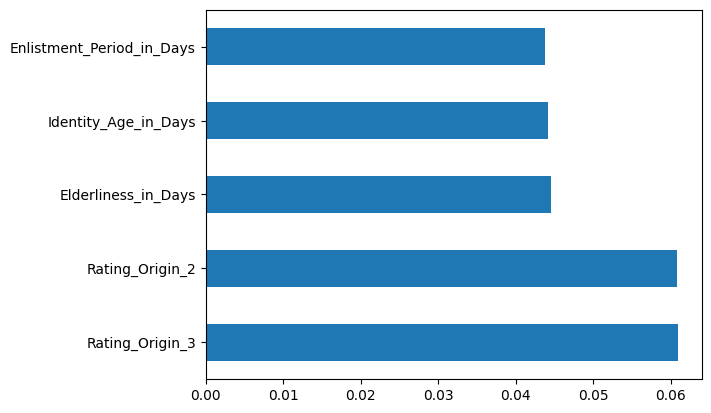

In [22]:
#plot important features
feat_imps=pd.Series(model.feature_importances_,index=X.columns)
feat_imps.nlargest(5).plot(kind='barh')
plt.show()

# Train Test split
Now that we have the features converted into numericals, we know the important features. We will split the data and start fitting it to various algorithms

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,random_state=7)


## Model Selection

###### Here We are using four regression algorithms .DecisionTrees and ensemble techniques like RandomForest,Adaboost,Xgboost and Catboost. 

In [24]:
from sklearn.linear_model import LogisticRegression
logistic_reg = LogisticRegression()

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=150)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150)

In [26]:
y_pred = rf.predict(X_test)

In [34]:
def metric_calc(true,predicted):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)  
    return precision,recall,accuracy
    

In [35]:
from sklearn.metrics import accuracy_score,recall_score,precision_score

precision,recall,accuracy = metric_calc(y_test, y_pred)
print("Accuracy:", accuracy,"precision:",precision,"recall:",recall)

Accuracy: 0.9303553355034604 precision: 1.0 recall: 0.11781011781011781


33671


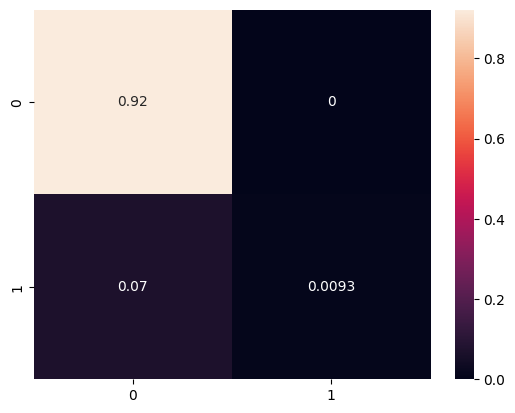

In [36]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
print(cm[0][0])
sns.heatmap(cm/np.sum(cm),annot=True)
labels = ['True Neg','False Pos','False Neg','True Pos']